In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from collections import namedtuple

In [2]:
# irisデータの読み込み
iris = datasets.load_iris()

In [3]:
# 構成を調べる
for key in iris.keys():
    print(key)

data
target
target_names
DESCR
feature_names


In [4]:
# 'feature_names' を確認
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

## 決定木モデル

## 分割基準の決定指標（ジニ係数）

ジニ最適な分割を決定するアルゴリズム

In [5]:
def gini(labels):
    """（サブ）データセットのカテゴリラベルに対してジニ係数を計算"""
    coef = 1 # 初期値
    N    = labels.size # （サブ）データセットの全体サイズ
    for lab in set(labels):
        coef -= (np.count_nonzero(labels == lab)/N)**2
    return coef

def try_division(labels, values):
    """カテゴリlabels、特徴量valuesのデータセットに対して最適な分割を計算し、
    分割場所を返す。分割しないほうが最適な場合は、NaNを返す"""
    
    def iterate_borders(values):
        """与えられた特徴量のセットvaluesから、境界線を計算"""
        sorted_values = values.copy()
        sorted_values.sort()
        border_candidates = (sorted_values[1:] + sorted_values[:-1])/2
        prev = np.nan
        for border in border_candidates.flatten():
            if border == prev:
                continue
            else:
                yield border
                prev = border
    
    def divide(values, border):
        return (values < border), (values >= border)
    
    # 最適解：「分割しない」で初期化
    opt_border = np.nan
    opt_gini   = gini(labels)
    
    # 全ての境界線を試してジニ係数を計算
    for _border in iterate_borders(values):
        _splitL, _splitR = divide(values, _border)
        _gini = gini(labels[_splitL]) + gini(labels[_splitR])
        
        # 現在の最小値より小さかった場合のみ、最適解を更新
        if _gini < opt_gini:
            opt_gini   = _gini
            opt_border = _border
            
    return opt_border

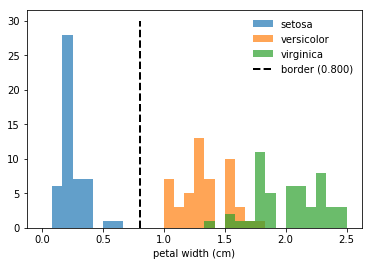

In [7]:
iris        = datasets.load_iris()
target      = iris['target']
petal_width = iris['data'][:,3]

border = try_division(target, petal_width)

fig = plt.figure()
for label in set(target):
    group = (target == label)
    plt.hist(petal_width[group], range=(0, 2.5), bins=30, alpha=.7, 
            label=iris['target_names'][label])
plt.vlines(border, 0, 30, color='k', linestyles='dashed', linewidth=2,
           label=f"border ({border:.3f})")
plt.xlabel(iris['feature_names'][3])
plt.legend(frameon=False)
fig.savefig('images/decisiontree_division_output.png')
plt.show()

### 決定木アルゴリズムの実装


In [8]:
def iterate_divisors(values, column_names=None):
    """与えられた(observations, features)の行列から分割方法をDivisorとして取り出すジェネレータを生成する。
    column_namesはvaluesの各特徴量の名前で、Divisorの名前として渡される。
    """
    n_obs, n_feats = values.shape
    if column_names is None:
        column_names = [f"feature{i+1}" for i in range(n_feats)]
        
    def get_column(j):
        """特徴量行列からj番目の特徴量を取り出す関数を返す"""
        def selector(values):
            return values[:,j]
        return selector
    
    for j in range(n_feats):
        selector     = get_column(j)    # j番目の特徴量を取り出す関数を得る
        feature      = selector(values) # j番目の特徴量を得る
        feature_name = column_names[j]  # j番目の特徴量の名前を得る
        
        # ソートして、可能な境界線を計算
        sorted_values = values.copy()
        sorted_values.sort()
        border_candidates = (sorted_values[1:] + sorted_values[:-1])/2
        prev = np.nan
        for border in border_candidates.flatten():
            if border == prev:
                continue
            else:
                yield Divisor(feature_name, selector, border)
                prev = border

class Divisor:
    """分割方法を表すクラス。特徴量としては数量のみに特化し、カテゴリ変数は無視する。"""
    
    def __init__(self, name, selector, border):
        """分割基準を初期化する。
        name     -- この基準の名前
        selector -- (observations, features)の行列から特定の特徴量を取り出す関数
        border   -- selectorで得られる特徴量を基準にした分割境界
        """
        self.name   = name
        self.get    = selector
        self.border = border
    
    def __repr__(self):
        return f"Divisor({self.name} <> {self.border:.3f})"
    
    def __call__(self, values):
        """与えられた(observations, features)の行列を用いて分割を行なう。
        (values < border), (values >= border)のマスクのタプルを返す"""
        feature = self.get(values)
        return (feature < self.border), (feature >= self.border)

In [9]:
class Growth:
    """Node.grow()の結果を保持するための補助クラス"""
    
    branched = False  # grow()の結果、新しい枝分かれが起こったか
    tree     = None   # 結果の木
    gain     = 0      # このgrow()の結果、ジニ係数がどれだけ減ったか
    
    def __init__(self, branched, tree, gain):
        self.branched = branched
        self.tree     = tree
        self.gain     = gain
    
    def __repr__(self):
        return f"(GrowthStatus '{self.status()}': tree={self.tree})"
    
    def message(self):
        if self.branched:
            return f"--> G={self.tree.gini():.3f}; ∆={self.gain:.3f}"
        else:
            return f"*** G={self.tree.gini():.3f}"
    
    @classmethod
    def success(cls, tree, gain):
        return cls(True, tree, gain)
    
    @classmethod
    def failure(cls, tree):
        return cls(False, tree, 0)

In [10]:
class Node:
    """決定木のノード情報を保持するクラス"""
    label    = None  # このノードが出力する予測カテゴリ；最もサンプル数の多いものが保存される
    divisor  = None  # 子ノードがある場合に分割基準となるDivisorクラス。Noneなら葉ノード
    children = None  # 子ノード
    min_gini = 1e-6  # 現状以上の分割が必要になるジニ係数の最小値
    depth    = 0     # このノードの深さ
    logging  = False # ログ出力
    
    def __init__(self, values, labels, depth=0, column_names=None, logging=False):
        self._labels   = labels
        self._values   = values
        self._colnames = column_names
        self._depth    = depth
        self._gini     = gini(labels)
        self.label     = max(set(labels), key=lambda lab: np.count_nonzero(self._labels == lab))
        self.logging   = logging
    
    def __repr__(self):
        return f"Node({self._labels.size};depth={self._depth};G={self._gini:.3f})"
    
    def _basecopy(self, values=None, labels=None, depth=None):
        if labels is None:
            labels = self._labels
        if values is None:
            values = self._values
        if depth is None:
            depth = self._depth
        return self.__class__(values, labels, depth, self._colnames, self.logging)
    
    def _graft(self, children):
        """子ノードを入れ替える形で、このノードのコピーを作成する"""
        if self.divisor is None: # 子ノードなし
            raise RunrimeError("graft must be called when there are child nodes")
        copied = self._basecopy()
        copied.divisor  = self.divisor
        copied.children = children
        return copied
    
    def _split(self, divisor):
        """与えられたdivisorでデータ分割を行ない、分割された場合の木のコピーを返す。"""
        if self.divisor is not None:
            raise RunrimeError("split must be called when there are *no* child nodes")
        divided = self._basecopy()
        divided.divisor  = divisor
        divided.children = tuple(self._basecopy(self._values[sp], self._labels[sp], self._depth+1) \
                                 for sp in divisor(self._values))
        return divided
    
    def gini(self):
        """このノード以降の、決定木のジニ係数"""
        if self.divisor is None:
            return self._gini
        else:
            return sum(child.gini() for child in self.children)
    
    def grow(self):
        """このノードより先の部分の分割を増やすことを試みて、Growthを返す。"""
        if self.divisor is None: # 葉ノード
            
            # すでに単一カテゴリにじゅうぶん近いなら、これ以上の分割はしない
            if self._gini < self.min_gini:
                if self.logging == True:
                    print(f"no more growth on: {self}")
                return Growth.failure(self)
            
            # 最適分割境界の探索
            opt_div  = None
            opt_gini = self._gini
            # 全ての境界線を試してジニ係数を計算
            for _divisor in iterate_divisors(self._values, column_names=self._colnames):
                _splitL, _splitR = _divisor(self._values)
                _gini = gini(self._labels[_splitL]) + gini(self._labels[_splitR])
                # 現在の最小値より小さかった場合のみ、最適解を更新
                if _gini < opt_gini:
                    if self.logging == True:
                        print(f"updating: {self} / {_divisor}")
                    opt_gini = _gini
                    opt_div  = _divisor
            if opt_div is None:
                if self.logging == True:
                    print(f"no nice divisor found for: {self}")
                return Growth.failure(self)
            else:
                return Growth.success(self._split(opt_div), self._gini - opt_gini)
            
        else: # 子ノードあり
            grown = [child.grow() for child in self.children]
            
            # どちらも伸びなかったらそのまま終了
            if all(not status.branched for status in grown):
                if self.logging == True:
                    print(f"both children did not grow for: {self}")
                return Growth.failure(self)
            
            # その他の場合、gainの大きい方を伸ばす
            if grown[0].gain >= grown[1].gain:
                children = (grown[0].tree, self.children[1])
                gain     = grown[0].gain
            else:
                children = (self.children[0], grown[1].tree)
                gain     = grown[1].gain
            return Growth.success(self._graft(children), gain)
    
    def predict(self, values):
        """与えられたvaluesからカテゴリの予測値を返す。"""
        ret = np.empty(values.shape[0], dtype=int)
        if self.divisor is None: # 葉ノード
            ret[:] = self.label
        else:
            for child, ind in zip(self.children, self.divisor(values)):
                ret[ind] = child.predict(values[ind])
        return ret
    
    def validate(self, values, labels):
        """与えられた(labels, values)でバリデーションを行なう。予測があっていたかどうかをブール値で返す。"""
        prediction = self.predict(values)
        return (prediction == labels)
    
    def format(self, indent=0, labels=None):
        """木の構造がわかる形で出力する"""
        if labels is None:
            labels = set(self._labels)
        spaces = ' '*4*indent
        if self.divisor is not None:
            print(f"{spaces}-> ? {self.divisor.name} <> {self.divisor.border} (G={self._gini:.3f})")
            for child in self.children:
                child.format(indent=indent+1, labels=labels)
        else:
            sizes  = [np.count_nonzero(self._labels == lab) for lab in sorted(labels)]
            print(f"{spaces}-> {sizes} (G={self._gini:.3f})")

In [11]:
def build_decision_tree(values, labels, column_names=None, logging=False):
    """決定木を作る"""
    tree = Node(values, labels, column_names=column_names, logging=logging)
    while True:
        stat = tree.grow()
        if logging == True:
            print(stat.message())
        tree = stat.tree
        if not stat.branched:
            if logging == True:
                print("*** cannot grow more")
            break
        elif tree.gini == 0:
            if logging == True:
                print("*** reached limit")
            break
    return tree

In [12]:
column_names = iris['feature_names']
values = iris['data']
labels = iris['target']

In [13]:
tree = build_decision_tree(values, labels, column_names, logging=True)

updating: Node(150;depth=0;G=0.667) / Divisor(sepal length (cm) <> 4.800)
updating: Node(150;depth=0;G=0.667) / Divisor(petal length (cm) <> 3.250)
updating: Node(150;depth=0;G=0.667) / Divisor(petal length (cm) <> 3.000)
--> G=0.500; ∆=0.167
no more growth on: Node(50;depth=1;G=0.000)
updating: Node(100;depth=1;G=0.500) / Divisor(sepal length (cm) <> 7.050)
updating: Node(100;depth=1;G=0.500) / Divisor(petal length (cm) <> 4.600)
updating: Node(100;depth=1;G=0.500) / Divisor(petal length (cm) <> 4.700)
updating: Node(100;depth=1;G=0.500) / Divisor(petal length (cm) <> 5.100)
updating: Node(100;depth=1;G=0.500) / Divisor(petal length (cm) <> 4.800)
updating: Node(100;depth=1;G=0.500) / Divisor(petal length (cm) <> 4.750)
updating: Node(100;depth=1;G=0.500) / Divisor(petal width (cm) <> 1.750)
--> G=0.211; ∆=0.289
no more growth on: Node(50;depth=1;G=0.000)
updating: Node(54;depth=2;G=0.168) / Divisor(petal length (cm) <> 5.600)
no nice divisor found for: Node(46;depth=2;G=0.043)
--> G=

この決定木の構造を確認

In [14]:
tree.format()

-> ? petal length (cm) <> 3.0 (G=0.667)
    -> [50, 0, 0] (G=0.000)
    -> ? petal width (cm) <> 1.75 (G=0.500)
        -> ? petal length (cm) <> 5.6 (G=0.168)
            -> [0, 49, 3] (G=0.109)
            -> [0, 0, 2] (G=0.000)
        -> [0, 1, 45] (G=0.043)


In [15]:
validation = tree.validate(values, labels)
size  = validation.size
succ  = np.count_nonzero(validation)
erate = (size - succ)*100/size
print(f"{succ}/{size} successful ({erate:.2f}% error)")

146/150 successful (2.67% error)


## ランダムフォレスト

### ランダムフォレストの実装


In [16]:
class RandomForest:
    """ランダムフォレストのフィッティングを行なうクラス"""
    random_state = 539167
    
    def __init__(self, n_estimators=100, random_state=None, column_names=None, logging=False):
        self.n_estimators = n_estimators
        self.column_names = column_names
        if random_state is not None:
            self.random_state = random_state
        self.logging      = logging
        self.estimators   = None
        self.labels       = None
    
    def fit(self, values, labels):
        self.estimators = []
        self.labels     = sorted(set(labels))
        
        size    = values.shape[0]
        indices = np.arange(size)
        
        np.random.seed(self.random_state)
        for i in range(self.n_estimators):
            _indices   = np.random.choice(indices, size=size, replace=True)
            _labels    = labels[_indices]
            _values    = values[_indices,:]
            _estimator = build_decision_tree(_values, _labels, self.column_names, logging=self.logging)
            self.estimators.append(_estimator)
        return self
    
    def predict_proba(self, values):
        if self.estimators is None:
            raise RuntimeError("call 'fit' before prediction")
        # 各決定木から予測をとる：(observations x estimators)
        predictions = np.stack([est.predict(values) for est in self.estimators], axis=-1)
        # 予測をカテゴリ値ごとの統計に変換：(observations x categories)
        votes = np.stack([(predictions == lab).sum(-1) for lab in self.labels], axis=-1)
        probs = votes / (self.n_estimators)
        return probs # (observations x categories)
    
    def predict(self, values):
        probs = self.predict_proba(values)
        return np.array([self.labels[probs[i].argmax()] for i in range(values.shape[0])])
    
    def validate(self, values, labels):
        pred = self.predict(values)
        return (pred == labels)

In [17]:
_values = iris['data'][:,:2]
_labels = iris['target']
_names  = iris['feature_names']

forest = RandomForest(n_estimators=100, column_names=_names).fit(_values, _labels)
tree   = build_decision_tree(_values, _labels, column_names=_names)

for model, label in ((forest, 'forest'), (tree, 'tree')):
    validation = model.validate(_values, _labels)
    size  = validation.size
    succ  = np.count_nonzero(validation)
    erate = (size - succ)*100/size
    print(f"{label:>8s}: {succ}/{size} successful ({erate:.2f}% error)")

  forest: 99/150 successful (34.00% error)
    tree: 72/150 successful (52.00% error)
